## Dataset download and library imports

In [16]:
!pip3 install -q kaggle keras_tuner
!pip3 install -U keras 

In [17]:
import tensorflow as tf
import keras
import keras_tuner
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import random
import logging
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import layers

tf.get_logger().setLevel(logging.ERROR)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [18]:
os.environ['KAGGLE_USERNAME'] = "XXXX"
os.environ['KAGGLE_KEY'] = "XXXX"

!mkdir dataset
!kaggle datasets download -d gsimonx37/letterboxd
!unzip letterboxd.zip -d dataset

# remove corrupted image
!rm "dataset/posters/1059895.jpg"

#### Global Parameters

Set the `FAST_TRAIN` parameter to true for reducing the execution time of the notebook

In [19]:
FAST_TRAIN = True 

In [20]:
BATCH_SIZE = 128
SUBSAMPLING_COEFF = 1 if not FAST_TRAIN else 0.04
MAX_EPOCHS = 15 if not FAST_TRAIN else 1
LABEL_PATH = "dataset/genres.csv"
MODELS_PATH = "models/"
IMG_PATH = "dataset/posters/"
IMG_SHAPE = (224,224,3)
AUTO = tf.data.AUTOTUNE

## Dataset Preprocessing

#### Genre distribution in the dataset

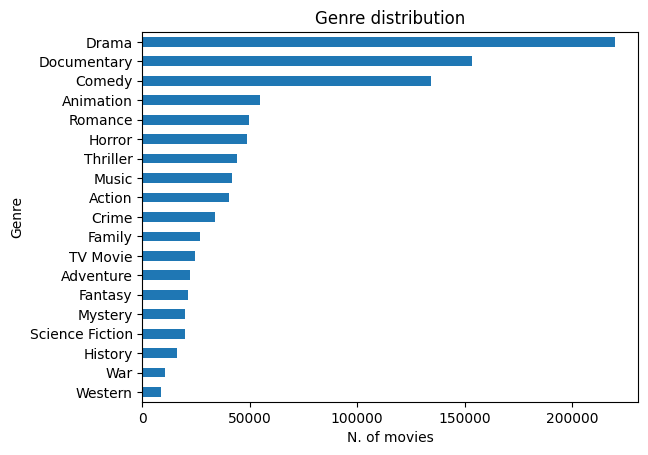

In [21]:
df = pd.read_csv(LABEL_PATH)
df.groupby("genre").count().sort_values(by="id").plot.barh(
    title="Genre distribution",
    xlabel="N. of movies",
    ylabel="Genre",
    log=False,
    legend=False,
)
plt.show()

In [22]:
df.head(8)

,id,genre
0,1000001,Comedy
1,1000001,Fantasy
2,1000001,Adventure
3,1000002,Comedy
4,1000002,Thriller
5,1000002,Drama
6,1000003,Science Fiction
7,1000003,Action


### Create the one-hot encoder for the labels

In [23]:
df["genre"] = df["genre"].apply(lambda x: x.replace(" ", "_"))
genres = df["genre"].unique()
genres = sorted(genres)

oneHotEncoder = sk.preprocessing.LabelBinarizer()
oneHotEncoder.fit(genres)

LabelBinarizer()

### Load and balance the Dataset

In [24]:
def load_ids(subsample=True) -> set[int]:
    df = pd.read_csv(LABEL_PATH)
    ID_set = set(df["id"])
    imageIDs = [int(f[:-4]) for f in os.listdir(IMG_PATH)]
    ID_set = ID_set.intersection(set(imageIDs))
    if subsample:
        return set(random.sample(list(ID_set), int(len(ID_set) * SUBSAMPLING_COEFF)))
    return ID_set


def load_labels(valid_IDs: set[int], multiLabel=False) -> pd.DataFrame:
    df = pd.read_csv(LABEL_PATH)
    df = df[df["id"].isin(valid_IDs)]
    if not multiLabel:
        sorted_genres = list(df.groupby("genre").count().sort_values(by="id").index)
        genre_importance = {genre: idx for idx, genre in enumerate(sorted_genres)}
        df["importance"] = df["genre"].map(genre_importance)
        df = df.sort_values(by=["id", "importance"])
        df = df.drop(columns=["importance"])
        df = df.drop_duplicates(subset="id", keep="first")
    df["genre"] = df["genre"].apply(lambda x: x.replace(" ", "_"))
    return df


def balance_labels(df: pd.DataFrame) -> pd.DataFrame:
    min_genre_count = df["genre"].value_counts().min()
    balanced_df = df.groupby("genre").apply(
        lambda group: group.sample(n=min_genre_count, replace=False),
    )
    balanced_df = balanced_df.reset_index(drop=True)
    return balanced_df


def encode_labels(df: pd.DataFrame) -> pd.Series:
    encodedLabels = oneHotEncoder.transform(df["genre"])
    encoded_df = pd.DataFrame({"id": df["id"], "label": list(encodedLabels)})
    return encoded_df.groupby("id").sum()


def load_image(record: dict) -> tuple[tf.Tensor, str]:
    image = tf.io.read_file(record["img"])
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_pad(
        image, target_height=IMG_SHAPE[1], target_width=IMG_SHAPE[0]
    )
    return image, record["label"]


def load_dataset(X: list[int], Y: list[str], reshuffle=True) -> tf.data.Dataset:
    labelTensor = tf.convert_to_tensor(list(oneHotEncoder.transform(Y)))
    image_files = [os.path.join(IMG_PATH, str(id) + ".jpg") for id in X]

    dataset = tf.data.Dataset.from_tensor_slices(
        {"img": image_files, "label": labelTensor}
    )
    dataset = dataset.shuffle(25_000, reshuffle_each_iteration=reshuffle)
    dataset = dataset.map(load_image, num_parallel_calls=AUTO)
    dataset = dataset.batch(
        batch_size=BATCH_SIZE,
        num_parallel_calls=AUTO,
        deterministic=False,
        drop_remainder=True,
    )
    dataset = dataset.prefetch(AUTO)
    return dataset


def make_splits(X: list[int], Y: list[str]) -> tuple[tf.data.Dataset]:
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.3, shuffle=True, stratify=Y
    )
    X_test, X_val, Y_test, Y_val = train_test_split(
        X_test, Y_test, test_size=0.5, shuffle=True, stratify=Y_test
    )
    return (
        load_dataset(X_train, Y_train),
        load_dataset(X_val, Y_val),
        load_dataset(X_test, Y_test, reshuffle=False),
        X_test
    )

In [25]:
ID_set = load_ids(subsample=(SUBSAMPLING_COEFF < 1))
labels = load_labels(ID_set, multiLabel=False)
labels = balance_labels(labels)
X = labels["id"].to_list()
Y = labels["genre"].to_list()

train_Data, validation_Data, test_Data, test_ID = make_splits(X, Y)

print("Number of labeled movie posters: ", labels["id"].unique().size)
print(f"Labels' Dataframe size: {labels.memory_usage().sum() / 1E6:.2f} MBs")
print("Number of datapoints per class: ", labels.groupby("genre").count()["id"].min())

/tmp/ipykernel_461384/21001667.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby("genre").apply(


Number of labeled movie posters:  148618
Labels' Dataframe size: 2.38 MBs
Number of datapoints per class:  7822


In [26]:
labels.groupby('genre').count()

,id
genre,
Action,7822
Adventure,7822
Animation,7822
Comedy,7822
Crime,7822
Documentary,7822
Drama,7822
Family,7822
Fantasy,7822


### Show a random datapoint

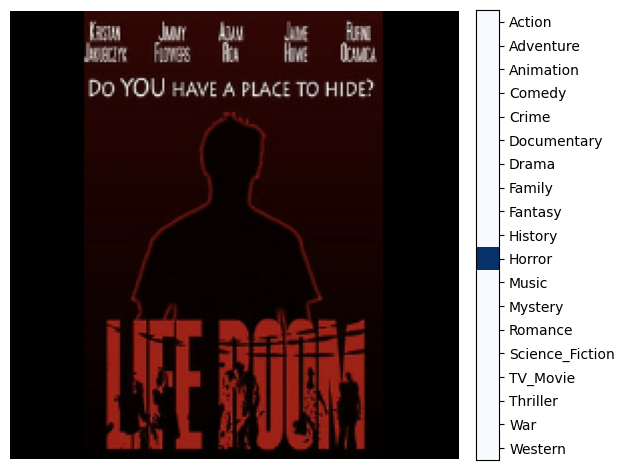

In [27]:
idx = random.randint(0, BATCH_SIZE - 1)
for img, label in train_Data.take(1).as_numpy_iterator():
    fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[5, 1], height_ratios=[1])
    img = img[idx]
    label = label[idx]
    ax1.imshow(img / 255)
    ax1.axis("off")
    data = np.array([label]).T
    cax = ax2.imshow(data, cmap="Blues", aspect="auto", interpolation="nearest")
    ax2.set_aspect(1)
    ax2.set_yticks(np.arange(len(label)))
    ax2.set_xticks([])
    ax2.set_yticklabels(genres)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.tight_layout()
    plt.show()
    break

#### Helper functions for plotting

In [28]:
def plot_datapoint(img: np.ndarray, label: np.ndarray, prediction: np.ndarray):
    _, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[5, 1], height_ratios=[1])
    ax1.imshow(img / 255)
    ax1.axis("off")
    data = np.vstack([label, prediction]).T
    ax2.imshow(data, cmap="Blues", aspect="auto", interpolation="nearest")
    ax2.set_aspect(0.9)
    ax2.set_yticks(np.arange(len(label)))
    ax2.set_xticks([0, 1])
    ax2.set_xticklabels(
        ["Label", "Prediction"], rotation=-50, ha="left", rotation_mode="anchor"
    )
    ax2.set_yticklabels(genres)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.tight_layout()
    plt.show()


def plot_random_datapoint(model: keras.Model, dataset: tf.data.Dataset):
    idx = random.randint(0, BATCH_SIZE - 1)
    for img, label in dataset.take(1).as_numpy_iterator():
        prediction = model.predict(tf.reshape(img[idx], (1, *IMG_SHAPE)), verbose=0)
        plot_datapoint(img[idx], label[idx], prediction)
        break


def plot_history(hst: keras.callbacks.History):
    metrics = ["loss", "accuracy", "recall"]
    _, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, metric in enumerate(metrics):
        ax[i].plot(hst.history[metric])
        ax[i].plot(hst.history["val_" + metric])
        ax[i].set(title="model " + metric, ylabel=metric, xlabel="epoch")
        ax[i].legend([metric, "val_" + metric], loc="upper left")
    plt.show()

def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 9))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt="g")
    ax.set_xlabel("Predicted", fontsize=20)
    ax.xaxis.set_label_position("bottom")
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(genres, fontsize=10)
    ax.xaxis.tick_bottom()
    ax.set_ylabel("Label", fontsize=20)
    ax.yaxis.set_ticklabels(genres, fontsize=10)
    plt.yticks(rotation=0)

    plt.title("Confusion Matrix", fontsize=20)
    plt.show()

## CNN training and evaluation

In [29]:
def build_model(hp: keras_tuner.HyperParameters):
    efficientNet = keras.applications.EfficientNetV2B0(
        include_top=False, input_shape=IMG_SHAPE, pooling="avg"
    )
    efficientNet.trainable = False

    input_layer = layers.Input(shape=IMG_SHAPE)
    x = efficientNet(input_layer, training=False)
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Dense(units=hp.Int("units", min_value=64, max_value=512, step=64))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if hp.Boolean("dropout"):
        x = layers.Dropout(0.3)(x)

    out = layers.Dense(19, "softmax", name="out_layer")(x)

    model = keras.Model(input_layer, out, name="efficientNet_poster")

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", "recall"],
    )
    return model

### Perform model selection 

In [30]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=1 if FAST_TRAIN else 4,
    executions_per_trial=1 if FAST_TRAIN else 2,
    overwrite=True,
    project_name="posterCNN",
)

tuner.search(train_Data, epochs=1 if FAST_TRAIN else 4, validation_data=validation_Data)

Trial 4 Complete [00h 11m 54s]
val_loss: 2.4319422245025635

Best val_loss So Far: 2.4186367988586426
Total elapsed time: 00h 45m 43s


In [31]:
tuner.results_summary()

Results summary
Results in ./posterCNN
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
units: 448
dropout: True
Score: 2.4186367988586426

Trial 3 summary
Hyperparameters:
units: 64
dropout: False
Score: 2.4319422245025635

Trial 2 summary
Hyperparameters:
units: 128
dropout: False
Score: 2.432430624961853

Trial 1 summary
Hyperparameters:
units: 256
dropout: False
Score: 2.4402326345443726


In [32]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
model = build_model(best_hyperparameters)
model.summary()

Model: "efficientNet_poster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 448)            │       459,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 448)            │         1,792 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 19)             │         8,531 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,704,675 (29.39 MB)

 Trainable params: 1,782,419 (6.80 MB)

 Non-trainable params: 5,922,256 (22.59 MB)

### Model training

In [33]:
earlyStop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    train_Data,
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS,
    validation_data=validation_Data,
    callbacks=[earlyStop],
)

Epoch 1/15
812/812 ━━━━━━━━━━━━━━━━━━━━ 102s 96ms/step - accuracy: 0.1799 - loss: 2.7641 - recall: 0.0340 - val_accuracy: 0.2414 - val_loss: 2.4454 - val_recall: 0.0440
Epoch 2/15
812/812 ━━━━━━━━━━━━━━━━━━━━ 75s 92ms/step - accuracy: 0.2387 - loss: 2.4516 - recall: 0.0441 - val_accuracy: 0.2451 - val_loss: 2.4325 - val_recall: 0.0511
Epoch 3/15
812/812 ━━━━━━━━━━━━━━━━━━━━ 71s 87ms/step - accuracy: 0.2610 - loss: 2.3805 - recall: 0.0510 - val_accuracy: 0.2484 - val_loss: 2.4265 - val_recall: 0.0599
Epoch 4/15
812/812 ━━━━━━━━━━━━━━━━━━━━ 71s 87ms/step - accuracy: 0.2792 - loss: 2.3155 - recall: 0.0603 - val_accuracy: 0.2500 - val_loss: 2.4265 - val_recall: 0.0594
Epoch 5/15
812/812 ━━━━━━━━━━━━━━━━━━━━ 75s 92ms/step - accuracy: 0.2918 - loss: 2.2665 - recall: 0.0696 - val_accuracy: 0.2493 - val_loss: 2.4516 - val_recall: 0.0754
Epoch 6/15
812/812 ━━━━━━━━━━━━━━━━━━━━ 75s 92ms/step - accuracy: 0.3123 - loss: 2.2000 - recall: 0.0821 - val_accuracy: 0.2459 - val_loss: 2.4652 - val_recall

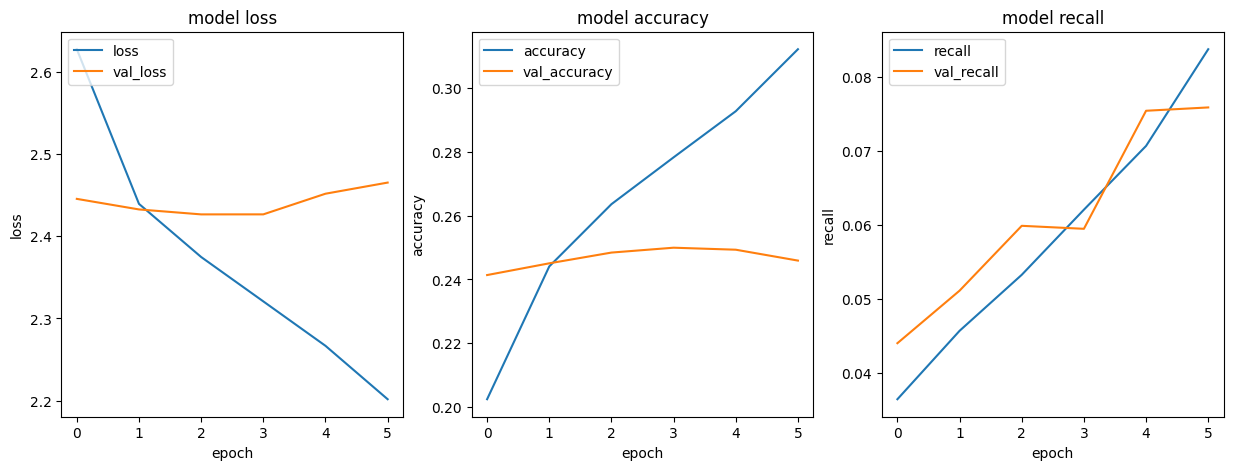

In [34]:
plot_history(history)

### Evaluation on the test set

In [35]:
test_loss, test_acc, test_recall = model.evaluate(test_Data, batch_size=BATCH_SIZE)

print(
    f"Test Loss: \t{test_loss:.3f}\nTest Accuracy: \t{test_acc:.3f}\nTest Recall: \t{test_recall:.3f}"
)

174/174 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.2480 - loss: 2.4267 - recall: 0.0575
Test Loss: 	2.426
Test Accuracy: 	0.248
Test Recall: 	0.057


### Classification report

In [36]:
y_pred = model.predict(test_Data)
y_pred_copy = []
for array in y_pred:
    max_idx = np.argmax([array])
    oneHot = np.zeros(19).astype(int)
    oneHot[max_idx] = 1
    y_pred_copy.append(oneHotEncoder.inverse_transform(np.array([oneHot])))

y_true = []
for batch in test_Data:
    for label in batch[1]:
        y_true.append(oneHotEncoder.inverse_transform(np.array([label])))

174/174 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step


2024-09-01 19:15:29.646457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
rep = sk.metrics.classification_report(y_true, y_pred_copy, output_dict=True)
rep = pd.DataFrame(rep).T
rep.support = rep.support.astype(int)
rep.round(decimals=2)

,precision,recall,f1-score,support
Action,0.23,0.28,0.25,1173
Adventure,0.18,0.11,0.14,1173
Animation,0.32,0.53,0.40,1171
Comedy,0.21,0.22,0.21,1173
Crime,0.15,0.13,0.14,1171
Documentary,0.18,0.24,0.20,1173
Drama,0.15,0.11,0.13,1173
Family,0.29,0.29,0.29,1171
Fantasy,0.24,0.12,0.15,1172
History,0.17,0.13,0.15,1172


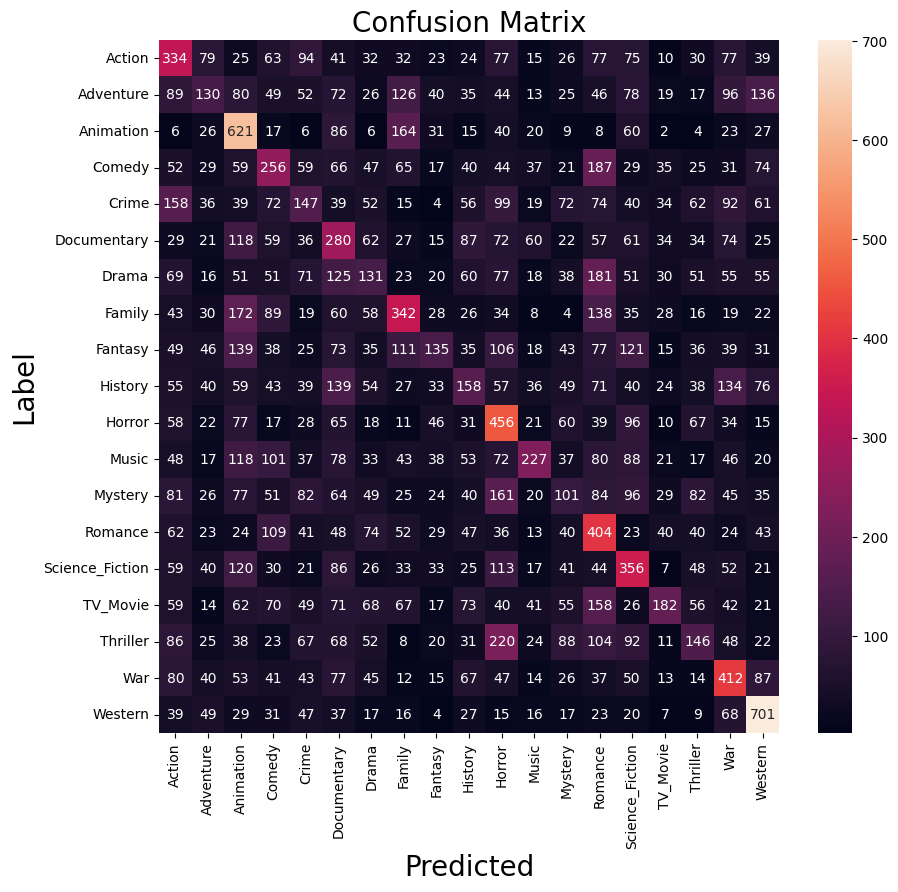

In [38]:
confusion_mat = sk.metrics.confusion_matrix(y_true, y_pred_copy)
plot_confusion_matrix(confusion_mat)

### Visualize the prediction

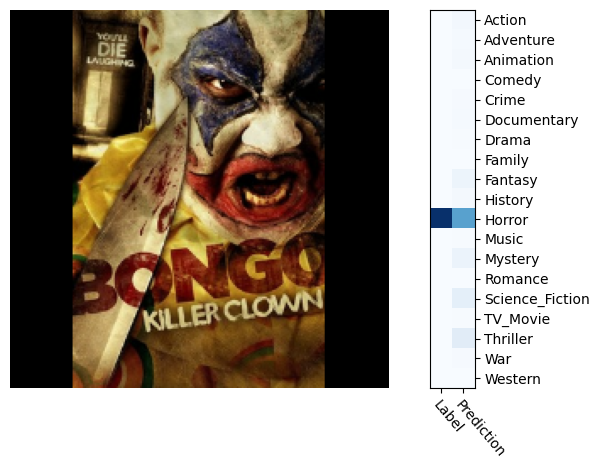

In [59]:
plot_random_datapoint(model, train_Data)

## One-vs-all multilabel classification

In [40]:
keras.backend.clear_session(free_memory=True)
N_GENRES = 4 if FAST_TRAIN else 19

In [41]:
class BinaryCNN:

    def __init__(self, frozen_layers: keras.Model, genre: str):
        self.genre = genre

        input_layer = layers.Input(shape=(224, 224, 3))
        x = frozen_layers(input_layer, training=False)

        x = layers.Dense(1000, name="dense_1")(x)
        x = layers.BatchNormalization(name="norm_1")(x)
        x = layers.Activation("relu")(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Dense(256, name="dense_2")(x)
        x = layers.BatchNormalization(name="norm_2")(x)
        x = layers.Activation("relu")(x)
        x = layers.Dropout(0.3)(x)

        out = layers.Dense(1, "sigmoid", name="out_layer")(x)

        self.model = keras.Model(input_layer, out, name=f"{genre}_classifier")
        self.model.compile(
            optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "recall"]
        )

    def fit(self, train_data, val_data):

        train_data = self.binarizeDataset(train_data)
        val_data = self.binarizeDataset(val_data)

        earlyStop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
        self.model.fit(
            train_data,
            batch_size=BATCH_SIZE,
            epochs=MAX_EPOCHS,
            validation_data=val_data,
            callbacks=[earlyStop],
        )

    def evaluate(self, test_data: tf.data.Dataset) -> tuple[float]:
        test_data = self.binarizeDataset(test_data)
        return self.model.evaluate(test_data, batch_size=BATCH_SIZE)

    def predict(self, data: tf.data.Dataset) -> float:
        return self.model.predict(data, verbose=False)

    def binarizeDataset(self, dataset: tf.data.Dataset) -> tf.data.Dataset:
        mask = oneHotEncoder.transform([self.genre])[0]

        binDataset = dataset.unbatch()
        binDataset = binDataset.map(
            lambda img, label: (img, tf.reduce_sum(label & mask))
        )
        binDataset = binDataset.batch(
            batch_size=BATCH_SIZE, num_parallel_calls=True, deterministic=False
        )

        return binDataset


class MultiLabelCNN:
    genres: list[str] = []
    binaryClassifiers: dict[str, BinaryCNN] = {}
    perf: dict[str, tuple] = {}

    def __init__(self, genre_list: list[str]):
        self.genres = genre_list.copy()
        self.split_ratio = 70 / 30
        efficientNet = keras.applications.EfficientNetV2B0(
            include_top=False,
            weights="imagenet",
            input_shape=(224, 224, 3),
            pooling="avg",
        )
        efficientNet.trainable = False

        for genre in genre_list:
            self.binaryClassifiers[genre] = BinaryCNN(efficientNet, genre)

    def fit(self):
        for genre in self.genres:
            X, Y = self.getBalancedData(genre)
            train_Data, val_Data, test_Data, _ = make_splits(X, Y)
            print(f"Training classifier for genre: {genre}")
            self.binaryClassifiers[genre].fit(train_Data, val_Data)

            loss, acc, recall = self.binaryClassifiers[genre].evaluate(test_Data)
            self.perf[genre] = (loss, acc, recall)

    def predict(self, data: tf.data.Dataset, batch_size=BATCH_SIZE) -> np.array:
        result = np.zeros((len(data)*batch_size, 19), dtype=float)
        for i, genre in enumerate(self.genres):
            result[:, i:i+1] = self.binaryClassifiers[genre].predict(data)
        return result

    def getPerfReport(self):
        rows = [[k, *v] for k, v in self.perf.items()]
        return pd.DataFrame(rows, columns=["genre", "loss", "accuracy", "recall"])

    def getBalancedData(self, genre: str) -> pd.DataFrame:
        movie_IDs = load_ids((SUBSAMPLING_COEFF < 1))
        movie_IDs = movie_IDs.difference(test_ID)
        groups = load_labels(movie_IDs).groupby("genre")
        num_genre_IDs = len(groups.get_group(genre))
        num_samples = min(num_genre_IDs, 10_000)

        # This check is needed to avoid over-sampling smaller classes
        # while preserving the overall class balance
        if (n := min(groups.count()["id"])) < (num_samples * self.split_ratio / 19):
            num_samples = int(n * 19 / self.split_ratio) - 1

        groups = groups.apply(
            lambda group: group.sample(
                n=(
                    num_samples
                    if group.name == genre
                    else int(num_samples * self.split_ratio / 19)  # 70/30 split
                )
            ),
        )
        groups = groups.reset_index(drop=True)
        return groups["id"].to_list(), groups["genre"].to_list()

In [42]:
multiLabel = MultiLabelCNN(genres[:N_GENRES])

In [ ]:
multiLabel.fit()

In [44]:
multiLabel.getPerfReport()

,genre,loss,accuracy,recall
0,Action,0.527464,0.741343,0.500678
1,Adventure,0.561454,0.707981,0.330853
2,Animation,0.377595,0.836360,0.738836
3,Comedy,0.527176,0.726562,0.411565
4,Crime,0.565842,0.706292,0.313261
5,Documentary,0.502007,0.737331,0.500000
6,Drama,0.575167,0.696157,0.285907
7,Family,0.520311,0.755912,0.464310
8,Fantasy,0.564595,0.716216,0.295670
9,History,0.569278,0.701014,0.355058


#### Classification report of the OvA when used in multi-class classification

In [45]:
y_pred = multiLabel.predict(test_Data) 

In [46]:
y_pred_copy = []
for array in y_pred:
    max_idx = np.argmax([array])
    oneHot = np.zeros(19).astype(int)
    oneHot[max_idx] = 1
    y_pred_copy.append(oneHotEncoder.inverse_transform(np.array([oneHot])))


y_true = []
for batch in test_Data:
    for label in batch[1]:
        y_true.append(oneHotEncoder.inverse_transform(np.array([label])))

2024-09-01 19:58:54.522300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [47]:
rep_OvA = sk.metrics.classification_report(y_true, y_pred_copy, output_dict=True)
rep_OvA = pd.DataFrame(rep_OvA).T
rep_OvA.support = rep_OvA.support.astype(int)
rep_OvA.round(decimals=2)

,precision,recall,f1-score,support
Action,0.21,0.30,0.25,1173
Adventure,0.16,0.08,0.11,1173
Animation,0.31,0.55,0.39,1171
Comedy,0.19,0.20,0.19,1173
Crime,0.14,0.09,0.11,1171
Documentary,0.18,0.26,0.21,1173
Drama,0.16,0.11,0.13,1173
Family,0.29,0.26,0.27,1171
Fantasy,0.24,0.10,0.15,1172
History,0.15,0.15,0.15,1172


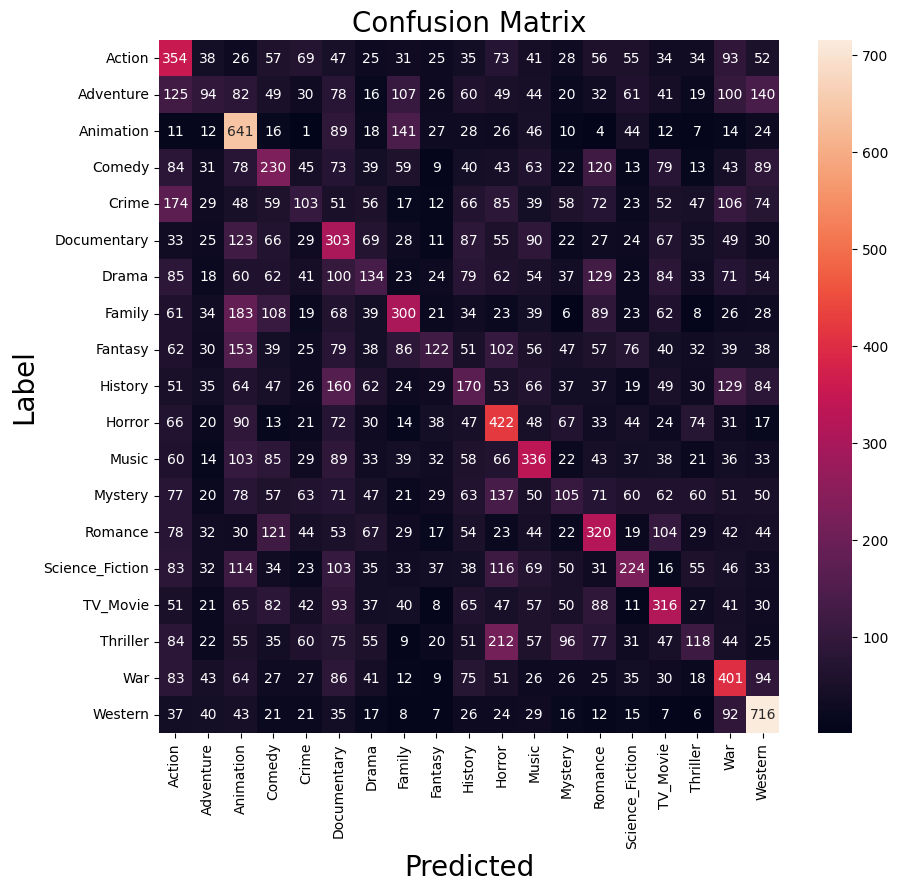

In [48]:
confusion_OvA = sk.metrics.confusion_matrix(y_true, y_pred_copy)
plot_confusion_matrix(confusion_OvA)

#### Plot an example of multi-label classification

In [49]:
ids = load_ids(subsample=.1)
multi_df = load_labels(ids, multiLabel=True)

#get movies that have more than one genre
multi_df = multi_df.groupby("id").filter(
    lambda group: len(set(genres[:N_GENRES]).intersection(group["genre"].to_list())) > 1
)
multi_df = encode_labels(multi_df)

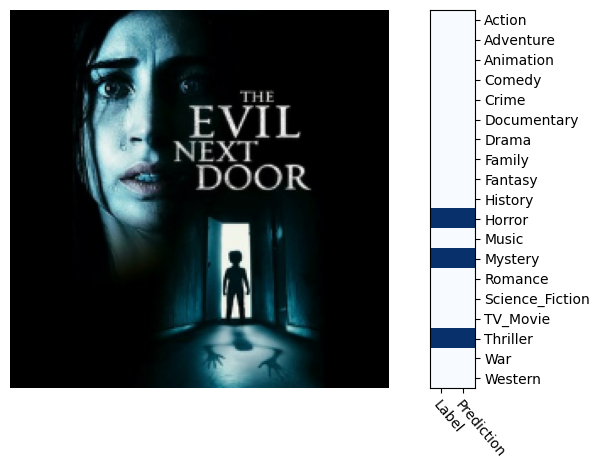

In [100]:
random_poster = multi_df.sample(1)
img_file = os.path.join(IMG_PATH, str(random_poster.index[0]) + ".jpg")
x, y = load_image({"img": img_file, "label": random_poster["label"]})
prediction = multiLabel.predict(tf.reshape(x, (1, *IMG_SHAPE)), 1)
prediction = (prediction > 0.5).astype(int)  # Binarize the prediction
plot_datapoint(x, np.array(*y), prediction)